 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

Notebook to combine actual Fraser River data with monthly climatologies for all the other rivers.

Steps to Create this Notebook:
* create daily files containing climatology for all rivers : done
* figure out how the Hope data compares to the climatology for the Fraser Drainage from Morrison : done
* replace Fraser information in the daily files with combined Hope/climatology data

In [1]:
# Standard Imports
from __future__ import division
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as NC
from salishsea_tools import nc_tools
import arrow
from salishsea_tools import rivertools
import yaml

In [2]:
# Constant and data ranges etc
year = 2015
smonth = 01
emonth = 01
startdate = arrow.get(year,smonth,04)
enddate = arrow.get(year,emonth,04)
print startdate, enddate

2015-01-04T00:00:00+00:00 2015-01-04T00:00:00+00:00


In [16]:
# get Fraser Flow data
filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
fraserflow = np.loadtxt(filename)
print fraserflow

[[ 2013.        4.        7.     1889.746]
 [ 2013.        4.        8.     1984.04 ]
 [ 2013.        4.        9.     2178.147]
 ..., 
 [ 2014.       11.        8.     2747.298]
 [ 2014.       11.        9.     2658.833]
 [ 2014.       11.       10.     2734.692]]


fraser has 10 rivers
0.984
42477.8
10821.7629395
414 334


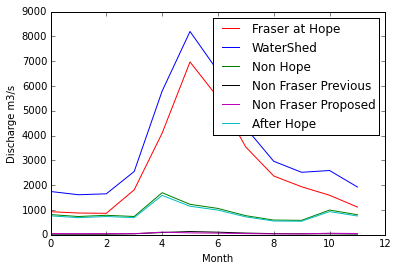

In [3]:
# Fraser River at Hope Seasonal Climatology (found in matlab using Mark's mean daily data)
climFraseratHope = (931, 878, 866, 1814, 4097, 6970, 5538, 3539, 2372, 1937, 1595, 1119)
# Climatology, Fraser Watershed
fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_monthly.nc','r')
climFraserWaterShed = fluxfile.variables['fraser'][:]
NonHope = climFraserWaterShed - climFraseratHope
plt.plot(climFraseratHope,'r', label="Fraser at Hope")
plt.plot(climFraserWaterShed,'b',label="WaterShed")
plt.plot(NonHope,'g',label="Non Hope")


# 
pd = rivertools.get_watershed_prop_dict('fraser')
totalfraser = (pd['Fraser1']['prop'] + pd['Fraser2']['prop'] + 
               pd['Fraser3']['prop'] + pd['Fraser4']['prop'])
print totalfraser
print climFraserWaterShed.sum()
print NonHope.sum()
print pd['Fraser1']['i'],pd['Fraser1']['j']
otherratio = 0.016
fraserratio = 1-otherratio

nonFraser = (otherratio * climFraserWaterShed.sum()/NonHope.sum()) * NonHope
afterHope = NonHope - nonFraser

FraserClimatologySeparation = {"Ratio that is not Fraser": otherratio,
                               "Ratio that is Fraser": fraserratio,
                               "non Fraser by Month": nonFraser.tolist(),
                               "after Hope by Month": afterHope.tolist()}

# write to file for us to use in production
with open('FraserClimatologySeparation.yaml', 'wt') as f:
    yaml.dump(FraserClimatologySeparation, f)

plt.plot(climFraserWaterShed*otherratio,'k',label="Non Fraser Previous")
plt.plot(nonFraser,'m',label="Non Fraser Proposed")
plt.plot(afterHope,'c',label="After Hope")
plt.legend()
plt.xlabel('Month')
plt.ylabel('Discharge m3/s')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Discharge m3/s')

In [4]:
# open monthly climatology
filename = '../../../nemo-forcing/rivers/rivers_month.nc'
clim_rivers = NC.Dataset(filename)
nc_tools.show_dimensions(clim_rivers)
nc_tools.show_variables(clim_rivers)
criverflow = clim_rivers.variables['rorunoff']
# get other variables so we can put them in new files
lat = clim_rivers.variables['nav_lat']
lon = clim_rivers.variables['nav_lon']
riverdepth = clim_rivers.variables['rodepth']
print criverflow.shape

<type 'netCDF4.Dimension'>: name = 'x', size = 398

<type 'netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 12

[u'nav_lat', u'nav_lon', u'time_counter', u'rorunoff', u'rodepth', u'rotemper']
(12, 898, 398)


In [15]:
def calculate_daily_flow(r,criverflow):
    '''interpolate the daily values from the monthly values'''
    print r.day, r.month
    if r.day < 16:
        prevmonth = r.month-1
        if prevmonth == 0:
            prevmonth = 12
        nextmonth = r.month
    else:
        prevmonth = r.month
        nextmonth = r.month + 1
        if nextmonth == 13:
            nextmonth = 1
    fp = r - arrow.get(year,prevmonth,15)
    fn = arrow.get(year,nextmonth,15) - r
    ft = fp+fn
    fp = fp.days/ft.days
    fn = fn.days/ft.days
    print ft, fp, fn
    driverflow = fn*criverflow[prevmonth-1] + fp*criverflow[nextmonth-1]
    return driverflow

In [6]:
def write_file(r,flow,lat,lon,riverdepth):
    ''' given the flow and the riverdepth and the date, write the nc file'''
    directory = '.'
    # set up filename to follow NEMO conventions
    filename = 'RFraserCElse_y'+str(year)+'m'+'{:0=2}'.format(r.month)+'d'+'{:0=2}'.format(r.day)+'.nc'
   # print directory+'/'+filename
    nemo = NC.Dataset(directory+'/'+filename, 'w')
    nemo.description = 'Real Fraser Values, Daily Climatology for Other Rivers' 
    
    # dimensions
    ymax, xmax = lat.shape
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0:1] = range(1,2)
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff._Fillvalue = 0.
    rorunoff._missing_value = 0.
    rorunoff._units = 'kg m-2 s-1'
    rorunoff[0,:] = flow
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth._Fillvalue = -1.
    rodepth.missing_value = -1.
    rodepth.units = 'm'
    rodepth = riverdepth
    nemo.close()
    return

In [7]:
def fraser_correction(pd, fraserflux, r, afterHope, NonFraser, fraserratio, otherratio,
                      runoff):
    ''' for the Fraser Basin only, replace basic values with the new climatology after Hope and the
     observed values for Hope.  Note, we are changing runoff only and not using/changing river
     depth '''
    for key in pd:
        if "Fraser" in key:
            flux = calculate_daily_flow(r,afterHope) + fraserflux
            subarea = fraserratio
        else:
            flux = calculate_daily_flow(r,NonFraser)
            subarea = otherratio
        
        river = pd[key]
        runoff = rivertools.fill_runoff_array(flux*river['prop']/subarea,river['i'],
                          river['di'],river['j'],river['dj'],river['depth'],
                          runoff,np.empty_like(runoff))[0]
    return runoff


2015-01-04T00:00:00+00:00
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
4 1
-334 days, 0:00:00 1.03293413174 -0.0329341317365
[ 4.90160942  3.37308645  2.8667028 ] 2.32842
1.97954 2.32842
0.00509887 0.00937893
0.338591 0.338591


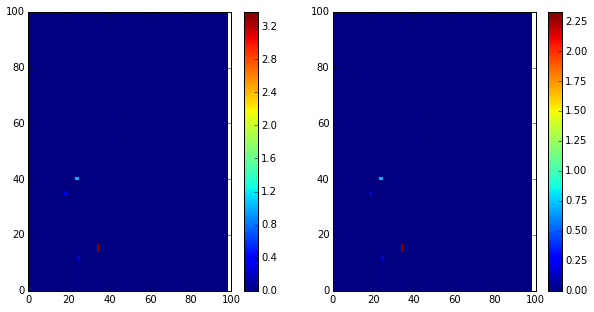

In [17]:
for r in arrow.Arrow.range('day', startdate, enddate):
    print r
    driverflow = calculate_daily_flow(r, criverflow)
    storeflow = calculate_daily_flow(r, criverflow)
#    step1 = fraserflow[fraserflow[:,0] == r.year]
#    step2 = step1[step1[:,1] == r.month]
#    step3 = step2[step2[:,2] == r.day]
#    print r.year, r.month, r.day, step3[0,3]
#    runoff = fraser_correction(pd, step3[0,3] , r, afterHope, nonFraser, fraserratio, otherratio,
#                               driverflow)
    runoff = fraser_correction(pd, 1250. , r, afterHope, nonFraser, fraserratio, otherratio,
                               driverflow)
    write_file(r,runoff,lat,lon,riverdepth)

fig, axs = plt.subplots(1,2,figsize=(10,5))
mesh = axs[0].pcolormesh(criverflow[8,400:500,300:400])
fig.colorbar(mesh,ax=axs[0])
mesh = axs[1].pcolormesh(runoff[400:500,300:400])
fig.colorbar(mesh,ax=axs[1])

ig = 414
jg = 334
print criverflow[7:10,414,334], driverflow[ig,jg]
print storeflow[ig,jg], driverflow[ig,jg]
ig = 351; jg = 345
print storeflow[ig,jg], driverflow[ig,jg]
ig = 749; jg=123
print storeflow[ig,jg], driverflow[ig,jg]


# jan 0, feb 1, mar 2, apr 3, may 4, jun 5
# jul 6, aug 7, sep 8